In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.bellhop import *
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# Celerity profile selection

In [2]:
s = bellhop({'mediterrannee': './SSP_4profils.mat'},name='cognac_cmap',rmax=50.)
#s.params

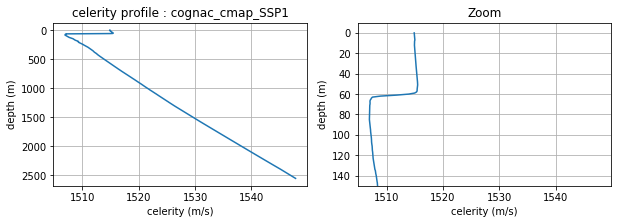

In [3]:
issp=0   # sound speed profile number
s.plotssp('mediterrannee', Issp=issp)

# Full arrival calculations on this profile

- *Bathymetry* : flat bottom at 2000 m depth

- *Source* : one source at 100m depth at range 0km

- *Receivers* : **Depth** : from 0 to 500m depth    /    **Range** : from 0 to 10 km 

In [4]:
# Generate .env file A

s.params['file_type'] = 'A'           # 'A' : arrivals time and amplitude file (.arr)
s.params['zs'] = 100.                 # source depth
s.params['ALimites'] = [-90.0, 90.0]  # limit angles

s.params['NDepth'] = 501              # number of receiver depths
s.params['zmin'] = 0.                 # minimum depth (m)
s.params['zmax'] = 500.               # maximum depth (m) (unuseful if NDepth=1)
                 

s.params['NRange'] = 10001            # number of receiver range    
s.params['rmin'] = 0.                 # minimum range (km)
s.params['rmax'] = 100.               # maximum range (km) (unuseful if NRange=1)            

s.params['zbox'] = 2500.              # box depth limit 
s.params['rbox'] = 101.               # box range limit 

s.generate_envfile('mediterrannee',file_env = s.params['name']+'_A.env', Issp=issp, SSP_depth_step=10)


In [5]:
Arr, Pos = s.read_arrivals_asc ('files_arr/cognac_2000m_test_A_full.arr', Narrmx = 15)

Max.number of arrivals for source index 0 is 10


In [6]:
Nsd = np.shape(Pos['s']['depth'])[0]
Nrd = np.shape(Pos['r']['depth'])[0]
Nrr = np.shape(Pos['r']['range'])[0]

print('number of source depths   : Nsd = ', Nsd)
print('number of receiver depths : Nrd = ', Nrd)
print('number of receiver ranges : Nrr = ', Nrr)

number of source depths   : Nsd =  1
number of receiver depths : Nrd =  501
number of receiver ranges : Nrr =  10001


#  I - Celerity map : Maximum amplitude 

Error dC between real and equivalent celerities with a detection by maximum of amplitude. 


In [ ]:
# error dc for all sources (only one here) and all receivers

s.params['file_type'] = 'E'          # 'E' : Eigenrays (.ray)
s.params['NDepth'] = 1               # number of receiver depths
s.params['NRange'] = 1               # number of receiver range   
s.params['NBeams'] = 5000 # 20000           # number of beams (if 0, bellhop choose automatically)


dstep = 10      # depth step (here 10m)
rstep = 100     # range step (here 1km)

DC = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )
DIFF = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )

for isd1 in range (Nsd):
    for ird1 in range (0,Nrd+1,dstep) :
        print('ird : %d/%d' %(ird1,Nrd))
        for irr1 in range (0,Nrr+1,rstep) : 
            Narr = int(Arr['Narr'][irr1, ird1, isd1])
            if not Narr ==0 :
                
                # Generate .env file E
                s.params['zmin'] = Pos['r']['depth'][ird1]          # receiver depth (m)
                s.params['rmin'] = Pos['r']['range'][irr1]/1000.    # receiver range (km)          
                s.generate_envfile('mediterrannee', file_env = s.params['name']+'_E.env', \
                                   Issp=issp, SSP_depth_step=50)
                
                # execute bellhop to obtain .ray
                subprocess.call(["bellhop.exe", s.params['name']+'_E'])
                
                # dictE from s.plotE (with plot=False)
                dictE = s.plotE (s.params['name']+'_E.ray', plot = False)
        
                # link between A and E (idx_E)
                angles_A = Arr['SrcAngle'][irr1, :Narr, ird1, isd1]
                angles_E = dictE['SrcAngle']
                
                if len(angles_E) >= len(angles_A) : 
                    idx_E = np.zeros_like(angles_A)
                    Diff = np.zeros_like(angles_A)

                    for i in range (len(angles_A)):
                        angle = angles_A[i]
                        diff = np.abs(angles_E - angle)
                        idx = diff.argmin()
                        a = angles_E[idx]

                        idx_E[i] = idx 
                        Diff[i] = angle - a


                    #real celerity for arrivals from .arr file
                    t = Arr['delay'][irr1, :Narr, ird1, isd1]
                    d = dictE['Dist']
                    c_real = np.zeros_like(angles_A)
                    for i in range (len(c_real)):
                        c_real[i] = d[int(idx_E[i])]/t[i]


                    # equivalent celerity
                    sr = 0.                         # source range(m)
                    sd = Pos['s']['depth'][isd1]    # source depth (m)
                    rr = Pos['r']['range'][irr1]    #receiver range (m)
                    rd = Pos['r']['depth'][ird1]    #receiver depth (m)

                    dist_eq = np.sqrt( (rr-sr)**2 + (rd-sd)**2)
                    c_eq = dist_eq / t


                    # diff of amplitude max
                    A = abs(Arr['A'][irr1, :Narr, ird1, isd1]) 
                    dc = c_real - c_eq
                    dc_max = dc [np.where(A==np.max(A))][0]
                    DC [int(irr1/rstep), int(ird1/dstep), isd1] = dc_max  
                    DIFF [int(irr1/rstep), int(ird1/dstep), isd1] = Diff[np.where(dc==dc_max)][0]
                    #print("La diff de célérité pour le max d'amplitude est de %.2f m/s." %dc_max)
                    #print('La différence entre les angles E et A est de %.2e°.' %Diff[np.where(dc==dc_max)][0])
                
                else : 
                    DC [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    DIFF [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    #print("Pas de diff de célérité calculée : pas assez de Eigenrays")
            else : 
                DC [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                DIFF [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                #print("Pas de diff de célérité calculée : pas d'arrivée")

In [ ]:
## saving arrays in .npy
np.save('DC_10m_1km_bis', DC)
np.save('DIFF_10m_1km', DIFF)

#DC = np.load('NPY/DC_10m_1km.npy')

In [46]:
DC = np.load('NPY/DC_10m_1km_bis.npy')
DIFF = np.load('NPY/DIFF_10m_1km.npy')

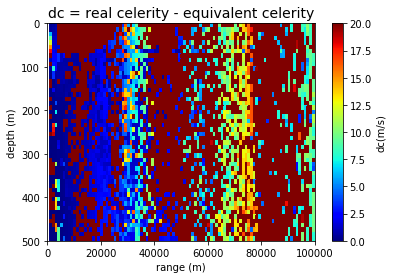

In [48]:
# PLOT 

isd = 0    # source number (only 1 source here)
R = Pos['r']['range']
Z = Pos['r']['depth']

r = R [::rstep]
z = Z [::dstep]
    
plt.pcolormesh(r, z, DC[:,:,isd].T, cmap='jet')
plt.title ('dc = real celerity - equivalent celerity', fontsize=14)
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dc(m/s)")
plt.clim ([0,20])
plt.gca().invert_yaxis()

#plt.xlim(1990,2050)
#plt.ylim(ymin = 295, ymax=305)

### % of accepted angles 

We work with 5151 receivers.


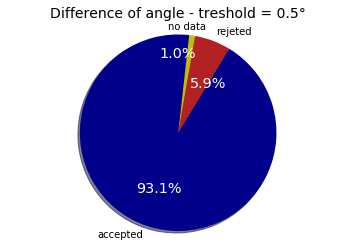

In [80]:
seuil = 0.5   # diff max acceptée entre les deux angles A et E (°)

tot = np.shape(DC)[0]*np.shape(DC)[1]
print('We work with %d receivers.' %tot)
accept = np.shape( np.where(DIFF<=seuil)[0] )[0]
no_data = np.shape( np.where(DIFF==0)[0] )[0]     # change by ==np.NaN next time

name = ['no data','accepted','rejeted']
data = [no_data, accept, tot-accept-no_data]
patches, texts, autotexts = plt.pie(data, labels=name, colors=['y','darkblue','firebrick'], \
                                    autopct='%1.1f%%', startangle=80, shadow=True)  
for t in autotexts:
    t.set_color('w')
    t.set_size('x-large')

autotexts[0].set_position((0.,0.8))
texts[0].set_position((-0.1,1.08))
autotexts[2].set_position((0.3,0.5))

plt.axis('equal')
plt.title ('Difference of angle - treshold = %.1f°' %seuil, fontsize=14)
plt.show()

#### TO DO : work with a detection treshold (is it better than max of amplitude ? )

# II - Celerity map : Detection treshold

In [8]:
# sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)

B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

#RT  = SL - TL - NL + DI + PG

In [ ]:
# error dc for all sources (only one here) and all receivers

s.params['file_type'] = 'E'          # 'E' : Eigenrays (.ray)
s.params['NDepth'] = 1               # number of receiver depths
s.params['NRange'] = 1               # number of receiver range   
s.params['NBeams'] = 5000 # 20000           # number of beams (if 0, bellhop choose automatically)


dstep = 10      # depth step (here 10m)
rstep = 100     # range step (here 1km)

seuil_d = 10    # detection treshold (dB)

DC1 = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )
DIFF1 = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )

for isd1 in range (Nsd):
    for ird1 in range (0,Nrd+1,dstep) :
        print('ird : %d/%d' %(ird1,Nrd))
        for irr1 in range (0,Nrr+1,rstep) : 
            Narr = int(Arr['Narr'][irr1, ird1, isd1])
            if not Narr ==0 :
                
                # Generate .env file E
                s.params['zmin'] = Pos['r']['depth'][ird1]          # receiver depth (m)
                s.params['rmin'] = Pos['r']['range'][irr1]/1000.    # receiver range (km)          
                s.generate_envfile('mediterrannee', file_env = s.params['name']+'_E.env', \
                                   Issp=issp, SSP_depth_step=50)
                
                # execute bellhop to obtain .ray
                subprocess.call(["bellhop.exe", s.params['name']+'_E'])
                
                # dictE from s.plotE (with plot=False)
                dictE = s.plotE (s.params['name']+'_E.ray', plot = False)
        
                # link between A and E (idx_E)
                angles_A = Arr['SrcAngle'][irr1, :Narr, ird1, isd1]
                angles_E = dictE['SrcAngle']
                
                if len(angles_E) >= len(angles_A) : 
                    idx_E = np.zeros_like(angles_A)
                    Diff = np.zeros_like(angles_A)

                    for i in range (len(angles_A)):
                        angle = angles_A[i]
                        diff = np.abs(angles_E - angle)
                        idx = diff.argmin()
                        a = angles_E[idx]

                        idx_E[i] = idx 
                        Diff[i] = angle - a


                    #real celerity for arrivals from .arr file
                    t = Arr['delay'][irr1, :Narr, ird1, isd1]
                    d = dictE['Dist']
                    c_real = np.zeros_like(angles_A)
                    for i in range (len(c_real)):
                        c_real[i] = d[int(idx_E[i])]/t[i]


                    # equivalent celerity
                    sr = 0.                         # source range(m)
                    sd = Pos['s']['depth'][isd1]    # source depth (m)
                    rr = Pos['r']['range'][irr1]    #receiver range (m)
                    rd = Pos['r']['depth'][ird1]    #receiver depth (m)

                    dist_eq = np.sqrt( (rr-sr)**2 + (rd-sd)**2)
                    c_eq = dist_eq / t


                    # diff of celerity for first detection 
                    dc = c_real - c_eq
                    
                    A = abs(Arr['A'][irr1, :Narr, ird1, isd1])
                    TL = - 20.0*np.log10(A)
                    RL = SL - TL - NL +DI + PG    # received level
                    t = Arr['delay'][irr1, :Narr, ird1, isd1]
                    t_ok = t[np.where(RL > seuil_d)]                    
                    if len(t_ok > 0): 
                        t_min = np.min(t_ok)
                        dc_first = dc[np.where(t==t_min)][0]  
            
                        DC1 [int(irr1/rstep), int(ird1/dstep), isd1] = dc_first 
                        DIFF1 [int(irr1/rstep), int(ird1/dstep), isd1] = Diff[np.where(dc==dc_first)][0]
                    #print("La diff de célérité pour le max d'amplitude est de %.2f m/s." %dc_max)
                    #print('La différence entre les angles E et A est de %.2e°.' %Diff[np.where(dc==dc_max)][0])
                    else : 
                        DC1 [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                        DIFF1 [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                        #print("Pas de diff de célérité calculée : pas de détection (arrivées<10dB)")
                
                else : 
                    DC1 [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    DIFF1 [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    #print("Pas de diff de célérité calculée : pas assez de Eigenrays")
            else : 
                DC1 [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                DIFF1 [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                #print("Pas de diff de célérité calculée : pas d'arrivée")

In [21]:
np.save('DC_first_10m_1km', DC1)
np.save('DIFF_first_10m_1km', DIFF1)

In [ ]:
DC1 = np.load('NPY/DC_first_10m_1km_bis.npy')
DIFF1 = np.load('NPY/DIFF_first_10m_1km.npy')

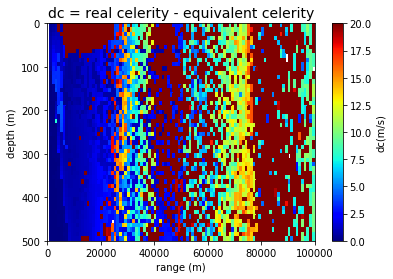

In [45]:
# PLOT 

isd = 0    # source number (only 1 source here)
R = Pos['r']['range']
Z = Pos['r']['depth']

r = R [::rstep]
z = Z [::dstep]
    
plt.pcolormesh(r, z, DC1[:,:,isd].T, cmap='jet')
plt.title ('dc = real celerity - equivalent celerity', fontsize=14)
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dc(m/s)")
plt.clim ([0,20])
#
#plt.xlim(0,20000)
#plt.ylim(100,500)
plt.gca().invert_yaxis()

- From 0 to 20km, dc is less than 3m/s. It seems better than the detection by maximum amplitude. 


- However, a difference of 3m/s on 20km represents a difference of position of 40m...  

### % of accepted angles 

We work with 5151 receivers.


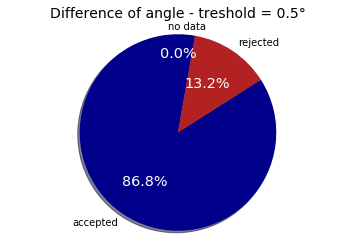

In [40]:
seuil = 0.5   # diff max acceptée entre les deux angles A et E (°)

tot = np.shape(DC1)[0]*np.shape(DC1)[1]
print('We work with %d receivers.' %tot)
accept = np.shape( np.where(DIFF1<=seuil)[0] )[0]
no_data = np.shape( np.where(DIFF1==0)[0] )[0]     # change by ==np.NaN next time

name = ['no data','accepted','rejected']
data = [no_data, accept, tot-accept-no_data]
patches, texts, autotexts = plt.pie(data, labels=name, colors=['y','darkblue','firebrick'], \
                                    autopct='%1.1f%%', startangle=80, shadow=True)  
for t in autotexts:
    t.set_color('w')
    t.set_size('x-large')

autotexts[0].set_position((0.,0.8))
texts[0].set_position((-0.1,1.08))
autotexts[2].set_position((0.3,0.5))

plt.axis('equal')
plt.title ('Difference of angle - treshold = %.1f°' %seuil, fontsize=14)
plt.show()